# Convolution - Filtering in the Spatial Domain

**Import**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [42]:
# Dieser Code kann so von der API kopiert werden
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 47.5584,
    "longitude": 7.5733,
    "start_date": "2015-01-01",
    "end_date": "2024-12-31",
    "hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Speichern der CSV-Datei
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)  # Erstelle den Ordner, falls er nicht existiert
csv_path = os.path.join(output_dir, "hourly_data.csv")

hourly_dataframe.to_csv(csv_path, index=False)

Coordinates 47.5571174621582°N 7.549342155456543°E
Elevation 283.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


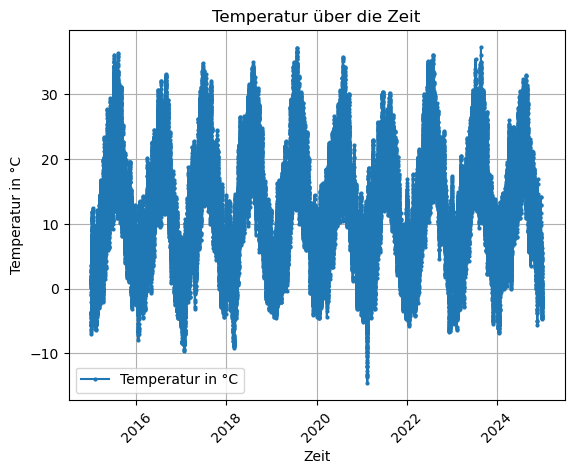

In [43]:
csv_path = "C:\\Users\silas\PycharmProjects\GBSV_2025\MC1\Data\hourly_data.csv"
if not os.path.exists(csv_path):
    print(f"Fehler: Datei {csv_path} nicht gefunden!")
else:
    daily_dataframe = pd.read_csv(csv_path, parse_dates=["date"])
    
    # Plot erstellen
    plt.plot(daily_dataframe["date"], daily_dataframe["temperature_2m"], linestyle="-", marker="o", markersize=2, label="Temperatur in °C")

    # Achsentitel und Beschriftungen
    plt.xlabel("Zeit")
    plt.ylabel("Temperatur in °C")
    plt.title("Temperatur über die Zeit")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

## Convolution - Implementing a Filtering Algorithm
**Was muss mein Algorythmuss beinhalten?**
Zunächst nehme ich die Eingabe meines Temperatursignals (1D-Signal). Anschliessend wende ich einen Filterkern an, der als Gewichtungsvektor fungiert. Dies ist bei meinem Beispiel ein einfacher Mittelwertfilter, der durch den Vektor [1/N, 1/N, ..., 1/N] dargestellt wird.

Die Faltungsoperation berechnet die gewichtete Summe über ein Fenster entlang des Signals. Dabei berücksichtige ich die Randbehandlung, die Methoden wie "zero-padding", "valid convolution" oder "full convolution" umfassen kann. Das bedeutet, dass ich beim Anwenden des Filters auf das Signal spezielle Techniken verwende, um die Ränder des Signals zu behandeln. Diese Techniken sind wichtig, weil die Ränder oft nicht vollständig von einem Filterkern abgedeckt werden. 

**Die Methoden im Detail:**

- Zero-padding: Ich füge Nullen an den Rändern des Signals hinzu, um sicherzustellen, dass der Filterkern vollständig über das Signal gleiten kann. (same)
- Valid convolution: Ich berechne die Faltung nur für die Teile des Signals, die vollständig vom Filterkern abgedeckt sind, und ignoriere die Ränder. (valid)
- Full convolution: Ich füge zusätzliche Nullen an den Rändern des Signals hinzu, sodass die Ausgabe die volle Faltung inklusive der Ränder enthält. (full)

Diese Methoden helfen, das Signal korrekt zu filtern und Verzerrungen an den Rändern zu vermeiden. Schliesslich liefert mein Algorithmus das gefilterte Signal als Ausgabe.

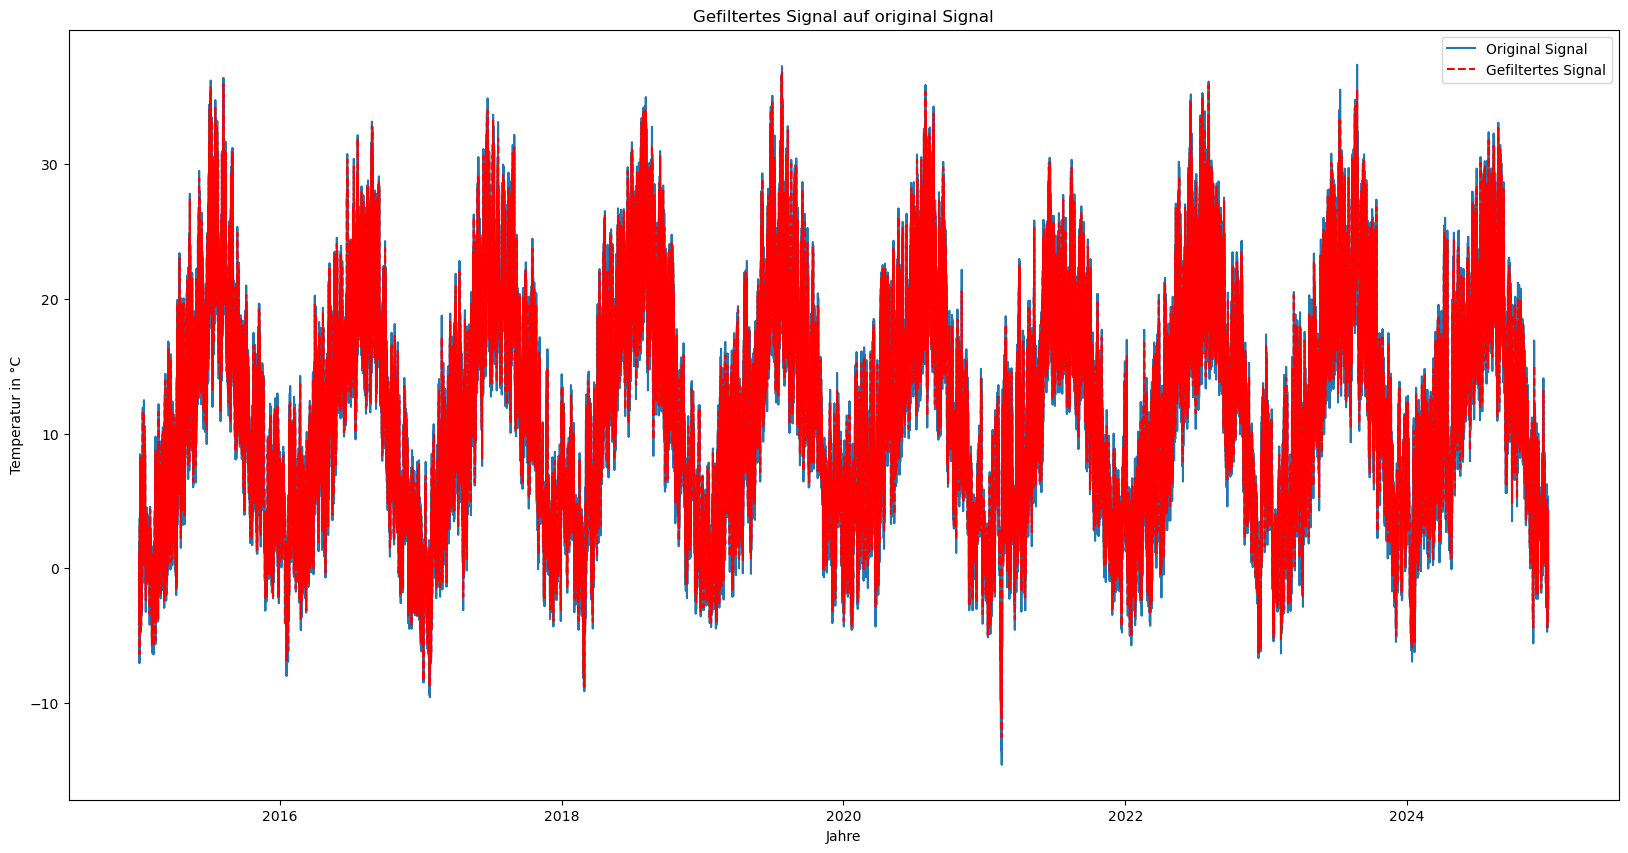

In [26]:
#drop NA
temperature_data = daily_dataframe["temperature_2m"].dropna()

# Definiere einen Mittelwertfilter
def moving_average_filter(signal, kernel_size, randbehandlungsmethode = 'same'):
    kernel = np.ones(kernel_size) / kernel_size
    filtered_signal_ = np.convolve(signal, kernel, mode=randbehandlungsmethode)  # Faltung
    return filtered_signal_

# Anwenden des Filters
filtered_signal = moving_average_filter(temperature_data, kernel_size=5)

# Plotten
plt.figure(figsize=(20, 10))
plt.plot(daily_dataframe["date"], temperature_data, label="Original Signal")
plt.plot(daily_dataframe["date"], filtered_signal, label="Gefiltertes Signal", linestyle="dashed", color="red")
plt.legend()
plt.title("Gefiltertes Signal auf original Signal")
plt.ylabel("Temperatur in °C")
plt.xlabel("Jahre")
plt.show()

### Problemstellung und Anwendungsfall
Ich möchte die Temperaturdaten von Basel während der Corona-Zeit mittels Convolution analysieren. Ziel ist es, die Auswirkungen der Pandemie auf die Temperaturverläufe zu visualisieren und zu quantifizieren. Dies könnte helfen, mögliche Zusammenhänge zwischen den Lockdown-Massnahmen und den Temperaturveränderungen zu erkennen.

### Visualisierung und Quantifizierung
Um die Temperaturdaten zu analysieren, werde ich die Zeitreihe der täglichen Durchschnittstemperaturen verwenden. Dabei werde ich einen Mittelwertfilter anwenden, um das Signal zu glätten und Trends besser sichtbar zu machen.

### Wahl der Methoden (Kernel) und Parameter
Für die Faltung des Signals werde ich die Randbehandlungsmethode Zero-padding verwenden. Diese Methode fügt Nullen an den Rändern des Signals hinzu, um sicherzustellen, dass der Filterkern vollständig über das Signal gleiten kann. Dies wird durch den Parameter same in der Faltungsfunktion erreicht.

**Warum Zero-padding (same)?**
- Zero-padding: Ich füge Nullen an den Rändern des Signals hinzu, um sicherzustellen, dass der Filterkern vollständig über das Signal gleiten kann. (same)
Die Wahl von Zero-padding hat mehrere Vorteile im Vergleich zu anderen Methoden:
1. Erhaltung der Signalgrösse: Die Ausgabe hat die gleiche Länge wie das Eingabesignal. Dies ist besonders nützlich, wenn die gefilterten Werte für jeden Punkt des ursprünglichen Signals benötigt werden, ohne dass die Länge des Signals verändert wird.
2. Einfache Implementierung: Zero-padding ist einfach zu implementieren und erfordert keine zusätzlichen Schritte zur Behandlung der Ränder. Dies macht den Algorithmus effizient und leicht verständlich.
3. Vermeidung von Randartefakten: Durch das Hinzufügen von Nullen an den Rändern wird sichergestellt, dass der Filterkern vollständig über das Signal gleiten kann, was zu einer gleichmässigen Faltung führt. Dies hilft, Artefakte an den Rändern des Signals zu vermeiden.

Im Vergleich dazu haben die anderen Methoden folgende Nachteile:
- Valid convolution: Diese Methode ignoriert die Ränder des Signals und berechnet die Faltung nur für die Teile des Signals, die vollständig vom Filterkern abgedeckt sind. Dies führt zu einer kürzeren Ausgabe, was problematisch sein kann, wenn die vollständige Länge des Signals benötigt wird.
- Full convolution: Diese Methode fügt zusätzliche Nullen an den Rändern des Signals hinzu, sodass die Ausgabe die volle Faltung inklusive der Ränder enthält. Dies führt zu einer längeren Ausgabe, was die Analyse und Interpretation der Ergebnisse erschweren kann.

Durch die Anwendung der Zero-padding-Methode hoffe ich, die Temperaturveränderungen während der Corona-Zeit in Basel klarer zu visualisieren und mögliche Zusammenhänge zu identifizieren.

**Beobachtungen zur Kernelgrösse**

Ich habe beobachtet, dass je grösser der Kernel wird, desto geglätteter ist das Signal. Um diesen Effekt zu veranschaulichen, habe ich das gefilterte Signal mit verschiedenen Kernelgrössen geplottet und das Originalsignal zum Vergleich hinzugefügt. Dies zeigt deutlich, wie die Glättung des Signals mit zunehmender Kernelgrösse zunimmt und hilft, langfristige Trends besser zu erkennen.

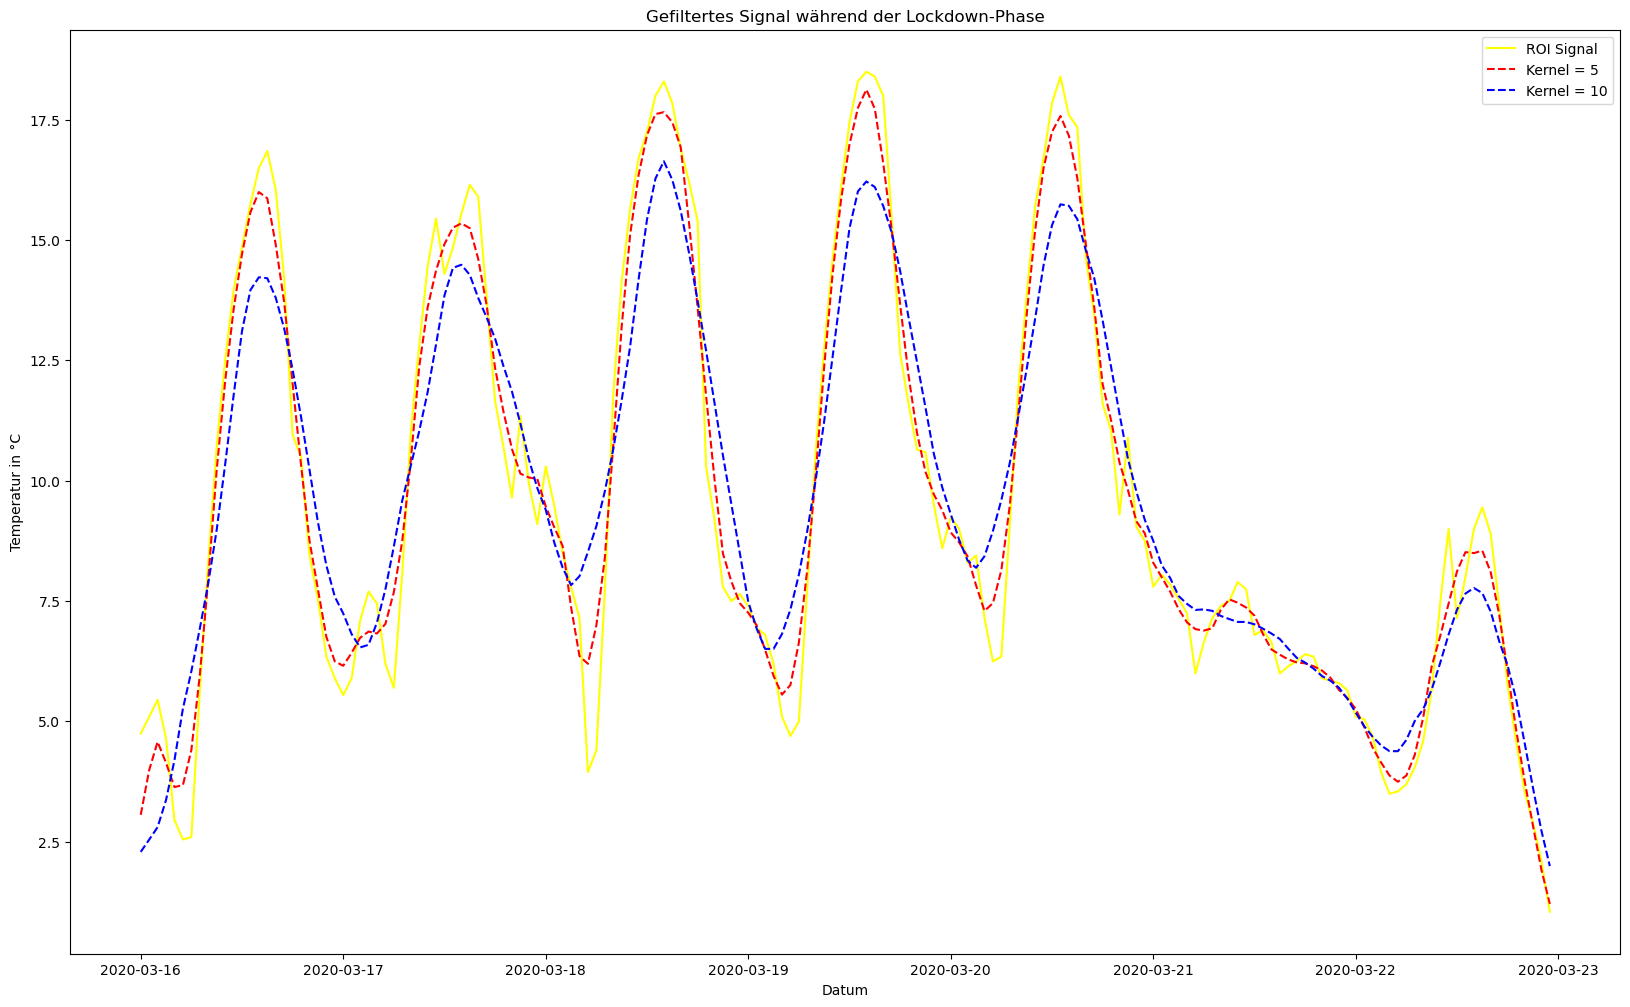

In [44]:
# CSV-Datei laden
df = pd.read_csv(csv_path, parse_dates=["date"])

# Setze die 'date'-Spalte als Index
df.set_index("date", inplace=True)

# Fehlende Werte in der Temperatur-Spalte entfernen
df = df.dropna(subset=["temperature_2m"])

# Zeitraum der Lockdown-Phase definieren
start = "2020-03-16"
end = "2020-03-22"

# Sicherstellen, dass das Zeitfenster existiert
roi = df.loc[start:end, "temperature_2m"]
roi_date = df.loc[start:end, "temperature_2m"].index  # Datum der Lockdown-Phase
full_signal = df["temperature_2m"]

# Anwenden des Filters auf das Signal während der Lockdown-Phase
filtered_roi_signal_5 = moving_average_filter(roi, kernel_size=5, randbehandlungsmethode = 'same')
filtered_roi_signal_10 = moving_average_filter(roi, kernel_size=10, randbehandlungsmethode = 'same')

# Plotten des Signals während der Lockdown-Phase
plt.figure(figsize=(20, 12))
plt.plot(roi_date, roi, label="ROI Signal", linestyle="solid", color="yellow")
plt.plot(roi_date, filtered_roi_signal_5, label="Kernel = 5", linestyle="dashed", color="red")
plt.plot(roi_date, filtered_roi_signal_10, label="Kernel = 10", linestyle="dashed", color="blue")
plt.legend()
plt.title("Gefiltertes Signal während der Lockdown-Phase")
plt.ylabel("Temperatur in °C")
plt.xlabel("Datum")
plt.show()

## Messung der Unterschiede vor und nach der Filterung
Zur Quantifizierung der Unterschiede zwischen den gefilterten und den Originaldaten verwendete ich zwei Fehlermasse:
Der Mittlere Absolute Fehler (MAE) und der Mittlere Quadratische Fehler (MSE). Diese Methoden bieten eine einfache, aber aussagekräftige Möglichkeit, die Genauigkeit der Filterung zu bewerten und die Auswirkungen der Glättung auf das Signal zu quantifizieren.

### Quantitative Analyse: MAE und MSE
Der Mittlere Absolute Fehler (MAE) misst den durchschnittlichen Unterschied zwischen den Originaldaten und den gefilterten Daten, wobei der Fehler in jeder Zeitperiode absolut betrachtet wird. Ein niedriger MAE-Wert zeigt an, dass das gefilterte Signal näher am Originalsignal liegt und somit weniger verzerrt wurde.
Der Mittlere Quadratische Fehler (MSE) berücksichtigt den quadratischen Fehler, wodurch grössere Fehler stärker gewichtet werden. Ein niedriger MSE-Wert bedeutet, dass das Signal weniger stark verfälscht wurde und grössere Abweichungen weniger ausgeprägt sind.

### Die Ergebnisse der Fehleranalyse mit verschiedenen Filtergrössen (Kernel 5, Kernel 10) zeigten die folgenden Werte:
MAE (Kernel = 5): 0.5564, MSE (Kernel = 5): 0.5216

MAE (Kernel = 10): 1.2879, MSE (Kernel = 10): 2.5518

### Interpretation der Ergebnisse
Die Analyse zeigt, dass der Kernel mit der Grösse 5 im Vergleich zum Kernel mit der Grösse 10 insgesamt geringere Fehlerwerte aufwies. Insbesondere der MAE und MSE bei Kernel 5 waren niedriger, was darauf hinweist, dass dieser Filter das Signal besser geglättet hat, ohne wesentliche Details zu verlieren.
- **Kernel = 5:** Der kleinere Kernel hat das Signal weniger geglättet, was zu einem näheren Bezug zum Originalsignal führt. Das bedeutet, dass die feinen Schwankungen in der Temperatur über den Zeitraum hinweg besser erhalten bleiben.
- **Kernel = 10:** Der grössere Kernel hat das Signal stärker geglättet, was zu einer stärkeren Reduzierung der Schwankungen führt. Dies führt zu höheren Fehlerwerten, da grössere Abweichungen zwischen dem Originalsignal und dem gefilterten Signal entstanden sind.

### Wahl der quantitativen Analyse und Parameter
Die Wahl von MAE und MSE als Fehlermasse ist besonders geeignet, da beide Masse eine einfache und effektive Möglichkeit bieten, die Qualität der Filterung zu beurteilen. Der MAE gibt einen klaren Überblick über die durchschnittliche Fehlerhöhe, während der MSE zusätzliche Informationen über die Gewichtung grösserer Fehler liefert.

Die Parameter der Filterung, insbesondere die Kernelgrösse, sind entscheidend, da sie die Glättung des Signals beeinflussen. Kleinere Kernelgrössen erhalten mehr Details des Signals, während grössere Kernelgrössen stärkere Glättungen bewirken, aber möglicherweise wichtige Informationen verlieren.

### Fazit
Insgesamt lässt sich sagen, dass die Wahl des Filters und der Filtergrösse direkt die Ergebnisse und die Interpretation der Daten beeinflusst. Für die vorliegende Analyse, bei der feine Schwankungen der Temperatur über einen bestimmten Zeitraum untersucht wurden, scheint der Kernel mit der Grösse 5 die geeignetste Wahl zu sein, da er das Signal gut geglättet hat, ohne zu viele Details zu verfälschen. Grössere Kernelgrössen wie Kernel 10 haben zu einer stärkeren Glättung geführt, was jedoch mit höheren Fehlerwerten und einer grösseren Verzerrung des Signals verbunden war. Weitere Tests mit anderen Filtergrössen könnten helfen, den optimalen Kompromiss zwischen Glättung und Detailtreue zu finden.

Wenn ich jedoch einen langfristigen Temperaturtrend betrachten möchte, ist es sinnvoll, einen grösseren Kernel zu verwenden. Ein grösserer Kernel glättet das Signal stärker, wodurch kurzfristige Schwankungen reduziert und langfristige Trends besser sichtbar gemacht werden. Dies kann besonders nützlich sein, um allgemeine Temperaturverläufe und -muster über längere Zeiträume zu erkennen.

MAE (Kernel = 5): 0.5564, MSE (Kernel = 5): 0.5216
MAE (Kernel = 10): 1.2879, MSE (Kernel = 10): 2.5518


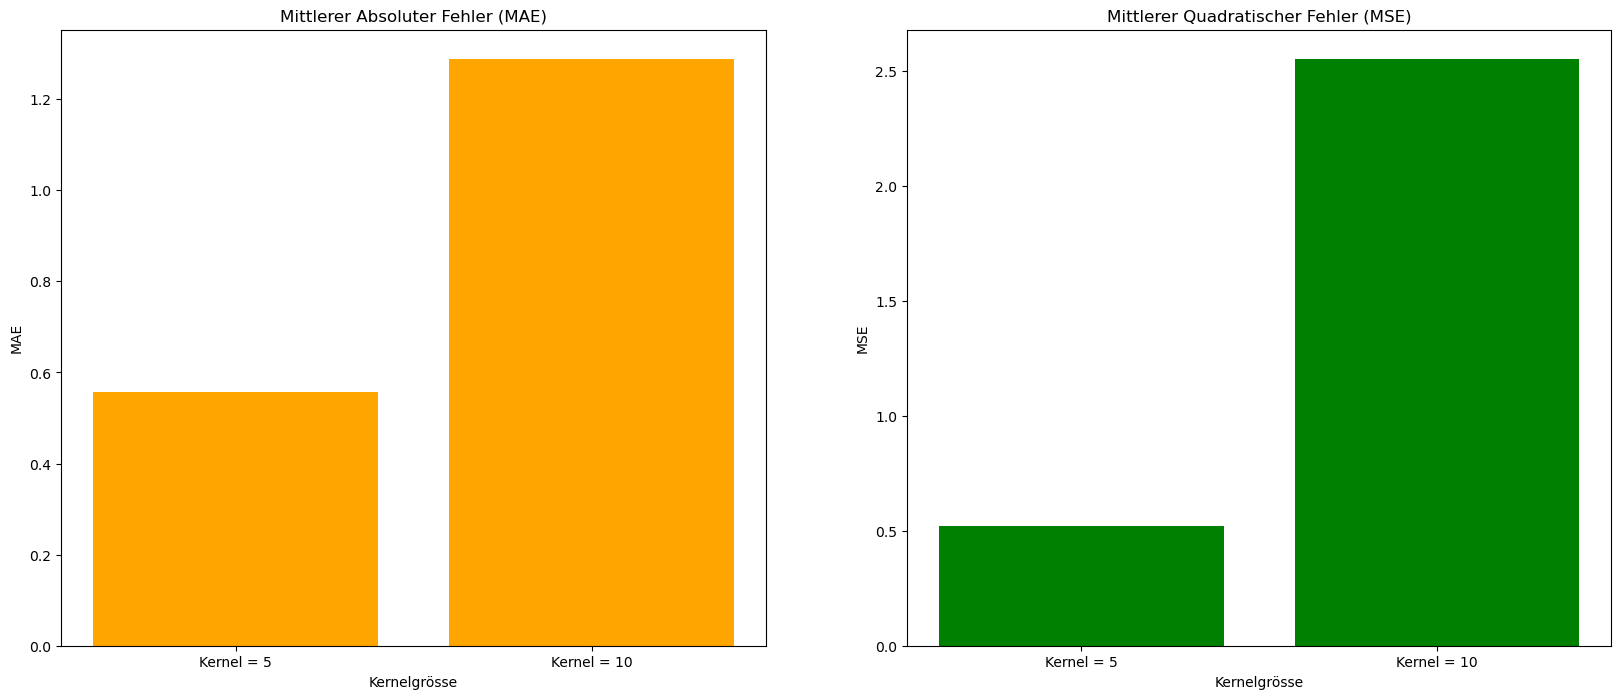

In [32]:
# Funktion zur Berechnung der Fehler (MAE und MSE)
def calculate_errors(original_signal, filtered_signal):
    mae = mean_absolute_error(original_signal, filtered_signal)
    mse = mean_squared_error(original_signal, filtered_signal)
    return mae, mse

# Berechnen der Fehler für die verschiedenen Filter
mae_5, mse_5 = calculate_errors(roi, filtered_roi_signal_5)
mae_10, mse_10 = calculate_errors(roi, filtered_roi_signal_10)

# Ausgabe der Fehlerwerte
print(f"MAE (Kernel = 5): {mae_5:.4f}, MSE (Kernel = 5): {mse_5:.4f}")
print(f"MAE (Kernel = 10): {mae_10:.4f}, MSE (Kernel = 10): {mse_10:.4f}")

# Plotten der Fehler (MAE und MSE)
error_labels = ["Kernel = 5", "Kernel = 10"]
mae_values = [mae_5, mae_10]
mse_values = [mse_5, mse_10]

# Erstellen des Subplots für MAE und MSE
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# MAE Plot
axs[0].bar(error_labels, mae_values, color='orange')
axs[0].set_title('Mittlerer Absoluter Fehler (MAE)')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('Kernelgrösse')

# MSE Plot
axs[1].bar(error_labels, mse_values, color='green')
axs[1].set_title('Mittlerer Quadratischer Fehler (MSE)')
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('Kernelgrösse')

plt.show()

### WAS und WARUM könnte die Entfaltung in diesem Anwendungsfall nützlich sein?

Die Entfaltung (Deconvolution) ist in diesem Anwendungsfall nützlich, da sie hilft, die Effekte der Glättung, die durch den Mittelwertfilter (oder andere Filtertechniken) auf das Temperatur-Signal angewendet wurden, rückgängig zu machen. Während des Lockdowns in Basel gab es möglicherweise starke Schwankungen in den Temperaturen, die durch verschiedene Faktoren wie wetterbedingte Veränderungen und regionale Einflüsse geprägt waren. Ein Filter, wie der Mittelwertfilter, wird häufig eingesetzt, um Rauschen und zufällige Schwankungen zu glätten, wodurch das Signal vereinfacht und langfristige Trends erkennbar werden.

Allerdings führt die Glättung dazu, dass feine Details und kurzfristige Schwankungen im Temperaturverlauf verloren gehen. In diesem speziellen Fall möchte man die Auswirkungen der Glättung "umkehren", um die ursprünglichen, unberührten Temperaturdaten zu rekonstruieren. Die Entfaltung ermöglicht es, das ursprüngliche Signal wiederherzustellen, indem sie die Glättungseffekte korrigiert und dabei hilft, die feineren Variationen im Signal, die durch die Glättung maskiert wurden, zurückzugewinnen.

Für die Analyse von Temperaturdaten während des Lockdowns ist die Entfaltung besonders nützlich, wenn man die spezifischen, kleineren Schwankungen der Temperaturen verstehen möchte, die in den gefilterten Daten nicht mehr sichtbar sind. Diese Schwankungen könnten durch aussergewöhnliche Wetterereignisse oder durch Veränderungen im städtischen Klima aufgrund der veränderten menschlichen Aktivitäten während des Lockdowns beeinflusst worden sein.

Zusätzlich könnte die Entfaltung auch hilfreich sein, um zu überprüfen, ob der Mittelwertfilter wirklich alle relevanten Muster entfernt hat oder ob wichtige Informationen im ursprünglichen Signal übersehen wurden. Besonders in wissenschaftlichen und meteorologischen Studien ist es entscheidend, so präzise wie möglich zu sein, um genauere Vorhersagen und Analysen des Klimas oder des Wetters treffen zu können.

Zusammengefasst könnte die Entfaltung dabei helfen, die durch den Filter verlorenen Details und kleinen Variationen im Temperaturverlauf wiederherzustellen und somit ein realistischeres Bild der Temperaturen während des Lockdowns zu erhalten.

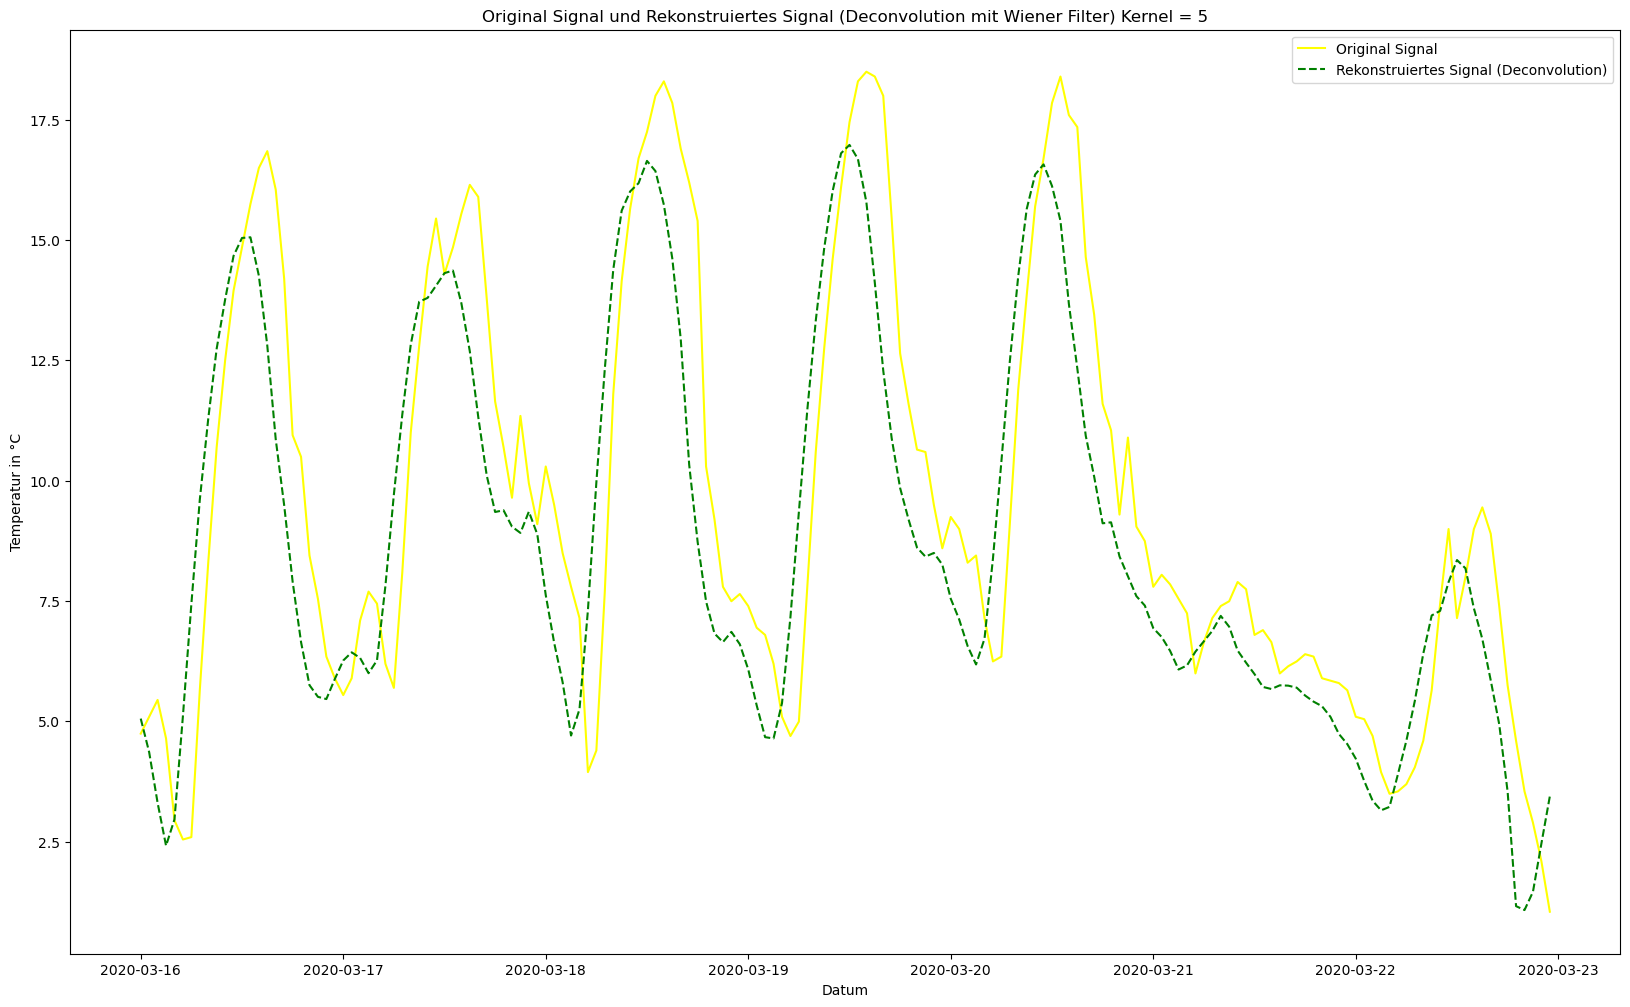

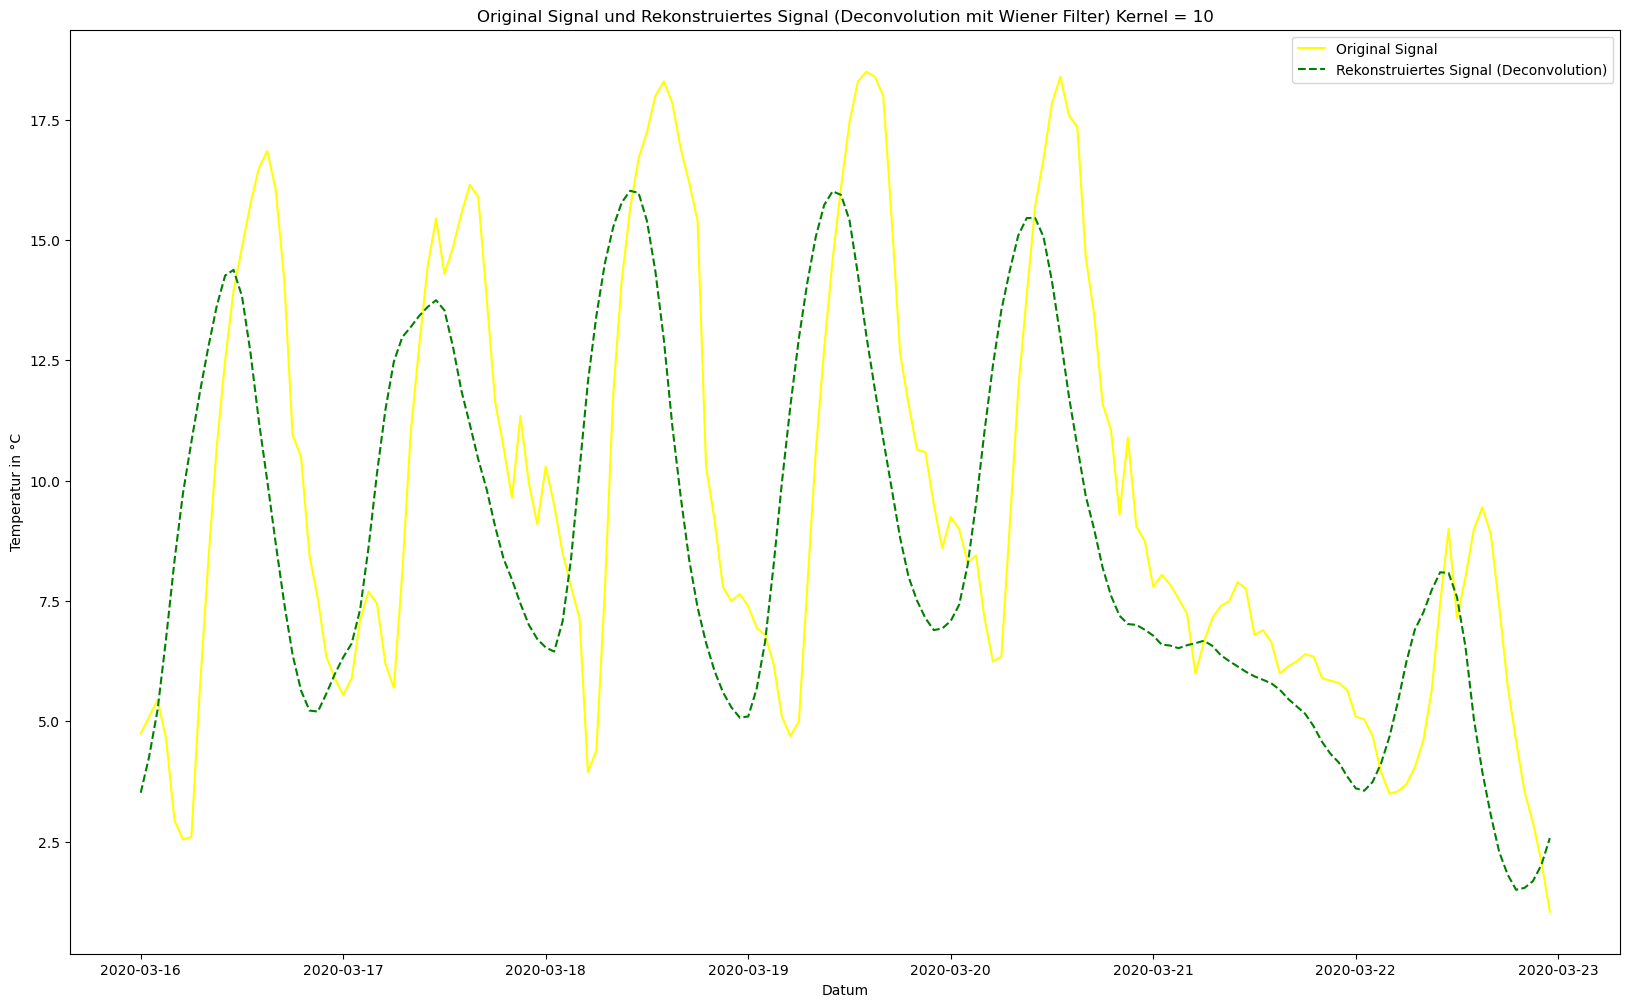

In [33]:
def wiener_deconvolution(filtered_signal, kernel_size, noise_estimation=0.09):
    kernel = np.ones(kernel_size) / kernel_size
    kernel_freq = np.fft.fft(kernel, len(filtered_signal))  # Fourier-Transformation des Kerns
    signal_freq = np.fft.fft(filtered_signal)  # Fourier-Transformation des gefilterten Signals
    
    # Wiener Deconvolution (berechnet den Filterinversen unter Annahme eines Rauschens)
    deconvolved_freq = (np.conj(kernel_freq) / (np.abs(kernel_freq)**2 + noise_estimation)) * signal_freq
    
    # Rücktransformation in den Zeitbereich
    deconvolved_signal = np.fft.ifft(deconvolved_freq).real
    return deconvolved_signal

# Anwenden der Wiener-Deconvolution auf das gefilterte Signal (Kernel = 5)
deconvolved_signal_5 = wiener_deconvolution(filtered_roi_signal_5, kernel_size=5)
deconvolved_signal_10 = wiener_deconvolution(filtered_roi_signal_10, kernel_size=10)

# Plotten des Originalsignals, des gefilterten Signals und des rekonstruierbaren Signals (Deconvolution)
plt.figure(figsize=(20, 12))
plt.plot(roi_date, roi, label="Original Signal", linestyle="solid", color="yellow")
plt.plot(roi_date, deconvolved_signal_5, label="Rekonstruiertes Signal (Deconvolution)", linestyle="dashed", color="green")
plt.legend()
plt.title("Original Signal und Rekonstruiertes Signal (Deconvolution mit Wiener Filter) Kernel = 5")
plt.ylabel("Temperatur in °C")
plt.xlabel("Datum")
plt.show()

# Plotten des Originalsignals, des gefilterten Signals und des rekonstruierten Signals (Deconvolution)
plt.figure(figsize=(20, 12))
plt.plot(roi_date, roi, label="Original Signal", linestyle="solid", color="yellow")
plt.plot(roi_date, deconvolved_signal_10, label="Rekonstruiertes Signal (Deconvolution)", linestyle="dashed", color="green")
plt.legend()
plt.title("Original Signal und Rekonstruiertes Signal (Deconvolution mit Wiener Filter) Kernel = 10")
plt.ylabel("Temperatur in °C")
plt.xlabel("Datum")
plt.show()

### Zusätzlich (war nicht in der aufgabe enthalten) danach geht es normal weiter mit dem Tag 12
Ich habe im Video in den Lernmaterialien gesehen, dass es auch die Gauss-Konvolution gibt, weshalb ich herausfinden wollte, was genau der unterschied ist. Mir viel vorallem beim Convolution auf, dass das Signal weniger fehler ist, da die Gauss-Konvolution aufgrund ihrer Matrix, welche in der Mitte den höchsten Wert hat, die Temperaturkurve weniger glättet, was bei dem Fehler MAE und MSE besser ist, jedoch beide nicht optimal für das Deconvolutin geeignet sind.

168


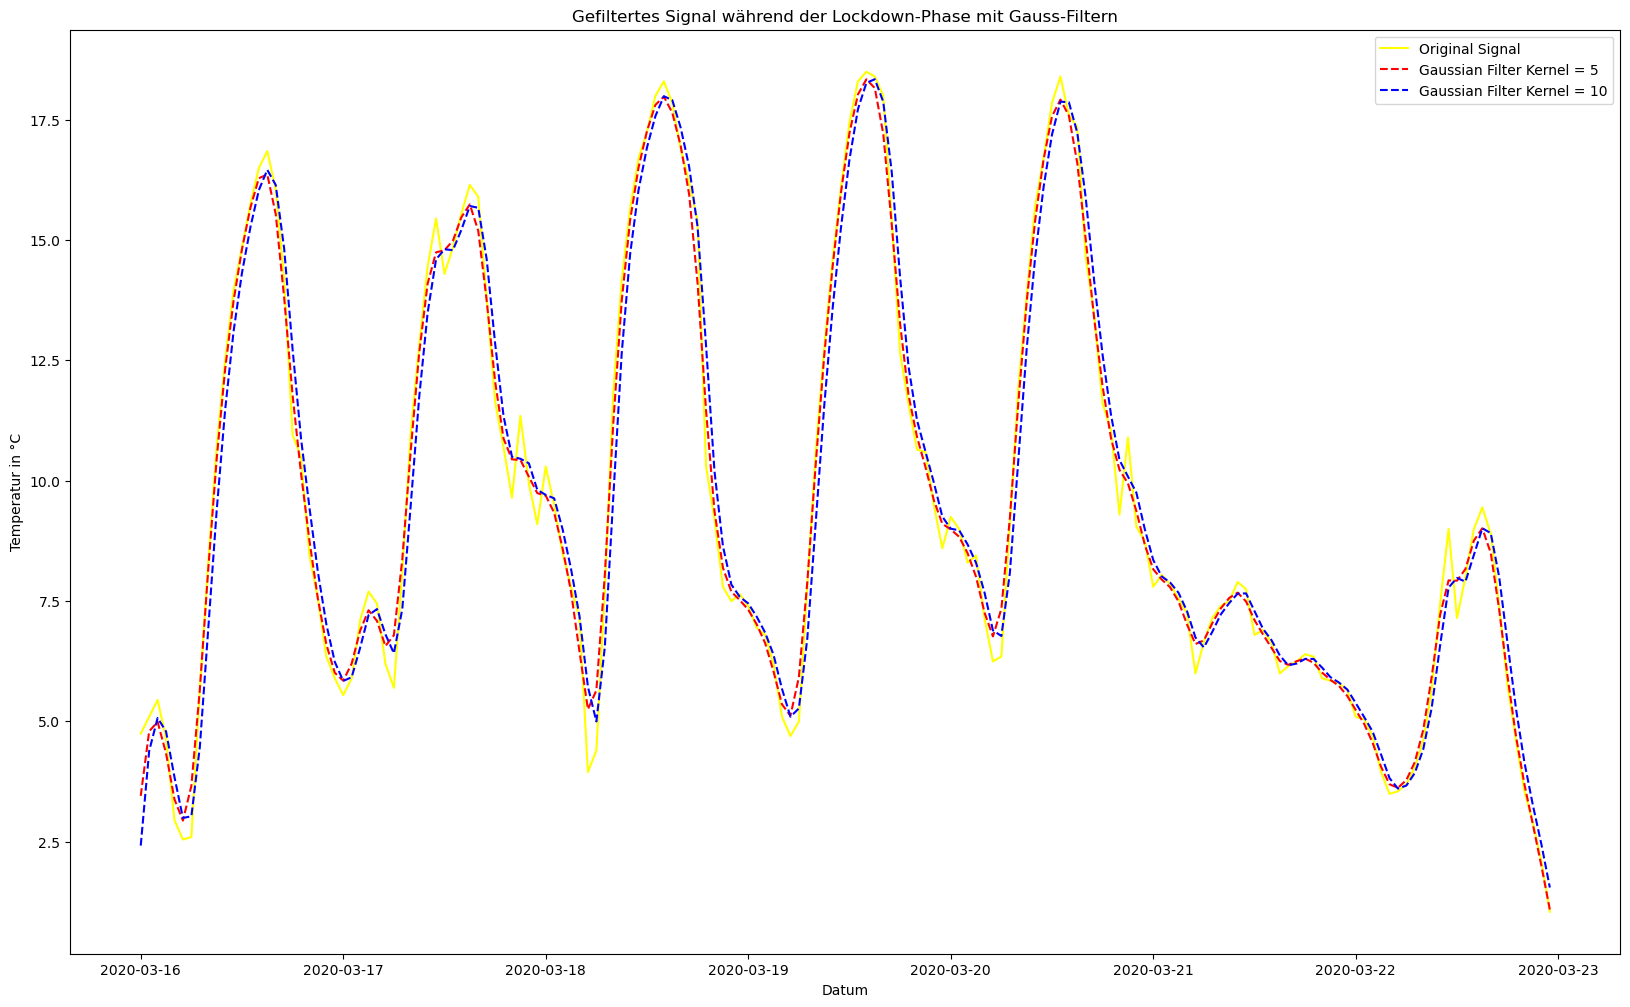

In [35]:
# Definiere eine Funktion für den Gauss-Mittelwertfilter
def gaussian_kernel(kernel_size, sigma=1.0):
    """Erstellt einen Gaussian Kernel mit gegebener Größe und Sigma."""
    kernel_range = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    kernel = np.exp(-kernel_range**2 / (2 * sigma**2))
    kernel /= kernel.sum()  # Normalisierung
    return kernel

def apply_gaussian_convolution(signal, kernel_size, sigma=1.0, randbehandlungsmethode='same'):
    """Wendet einen Gaussian Filter auf das Signal an."""
    kernel = gaussian_kernel(kernel_size, sigma)
    return np.convolve(signal, kernel, mode=randbehandlungsmethode)


df = pd.read_csv(csv_path, parse_dates=["date"])

# Setze die 'date'-Spalte als Index
df.set_index("date", inplace=True)

# Fehlende Werte in der Temperatur-Spalte entfernen
df = df.dropna(subset=["temperature_2m"])

# Zeitraum der Lockdown-Phase definieren
lockdown_start = "2020-03-16"
lockdown_end = "2020-03-22"

# Sicherstellen, dass das Zeitfenster existiert
roi = df.loc[lockdown_start:lockdown_end, "temperature_2m"]
roi_date = df.loc[lockdown_start:lockdown_end, "temperature_2m"].index  # Datum der Lockdown-Phase
full_signal = df["temperature_2m"]
print(len(roi))

# Anwenden des Gauss-Filters auf das Signal während der Lockdown-Phase
filtered_roi_signal_gaussian_5 = apply_gaussian_convolution(roi, kernel_size=5, sigma=1.0)
filtered_roi_signal_gaussian_10 = apply_gaussian_convolution(roi, kernel_size=10, sigma=1.0)

# Plotten des Signals während der Lockdown-Phase
plt.figure(figsize=(20, 12))
plt.plot(roi_date, roi, label="Original Signal", linestyle="solid", color="yellow")
plt.plot(roi_date, filtered_roi_signal_gaussian_5, label="Gaussian Filter Kernel = 5", linestyle="dashed", color="red")
plt.plot(roi_date, filtered_roi_signal_gaussian_10, label="Gaussian Filter Kernel = 10", linestyle="dashed", color="blue")
plt.legend()
plt.title("Gefiltertes Signal während der Lockdown-Phase mit Gauss-Filtern")
plt.ylabel("Temperatur in °C")
plt.xlabel("Datum")
plt.show()

In [36]:
# Funktion zur Berechnung der Fehler (MAE und MSE)
def calculate_errors(original_signal, filtered_signal):
    mae = mean_absolute_error(original_signal, filtered_signal)
    mse = mean_squared_error(original_signal, filtered_signal)
    return mae, mse

# Berechnen der Fehler für die verschiedenen Gauss-Filter
mae_5_gauss, mse_5_gauss = calculate_errors(roi, filtered_roi_signal_gaussian_5)
mae_10_gauss, mse_10_gauss = calculate_errors(roi, filtered_roi_signal_gaussian_10)

# Ausgabe der Fehlerwerte
print(f"MAE (Gaussian Kernel = 5): {mae_5_gauss:.4f}, MSE (Gaussian Kernel = 5): {mse_5_gauss:.4f}")
print(f"MAE (Gaussian Kernel = 10): {mae_10_gauss:.4f}, MSE (Gaussian Kernel = 10): {mse_10_gauss:.4f}")

# Plotten der Fehler (MAE und MSE)
error_labels_gauss = ["Kernel = 5", "Kernel = 10"]
mae_values_gauss = [mae_5_gauss, mae_10_gauss]
mse_values_gauss = [mse_5_gauss, mse_10_gauss]

MAE (Gaussian Kernel = 5): 0.3140, MSE (Gaussian Kernel = 5): 0.1841
MAE (Gaussian Kernel = 10): 0.5589, MSE (Gaussian Kernel = 10): 0.5364


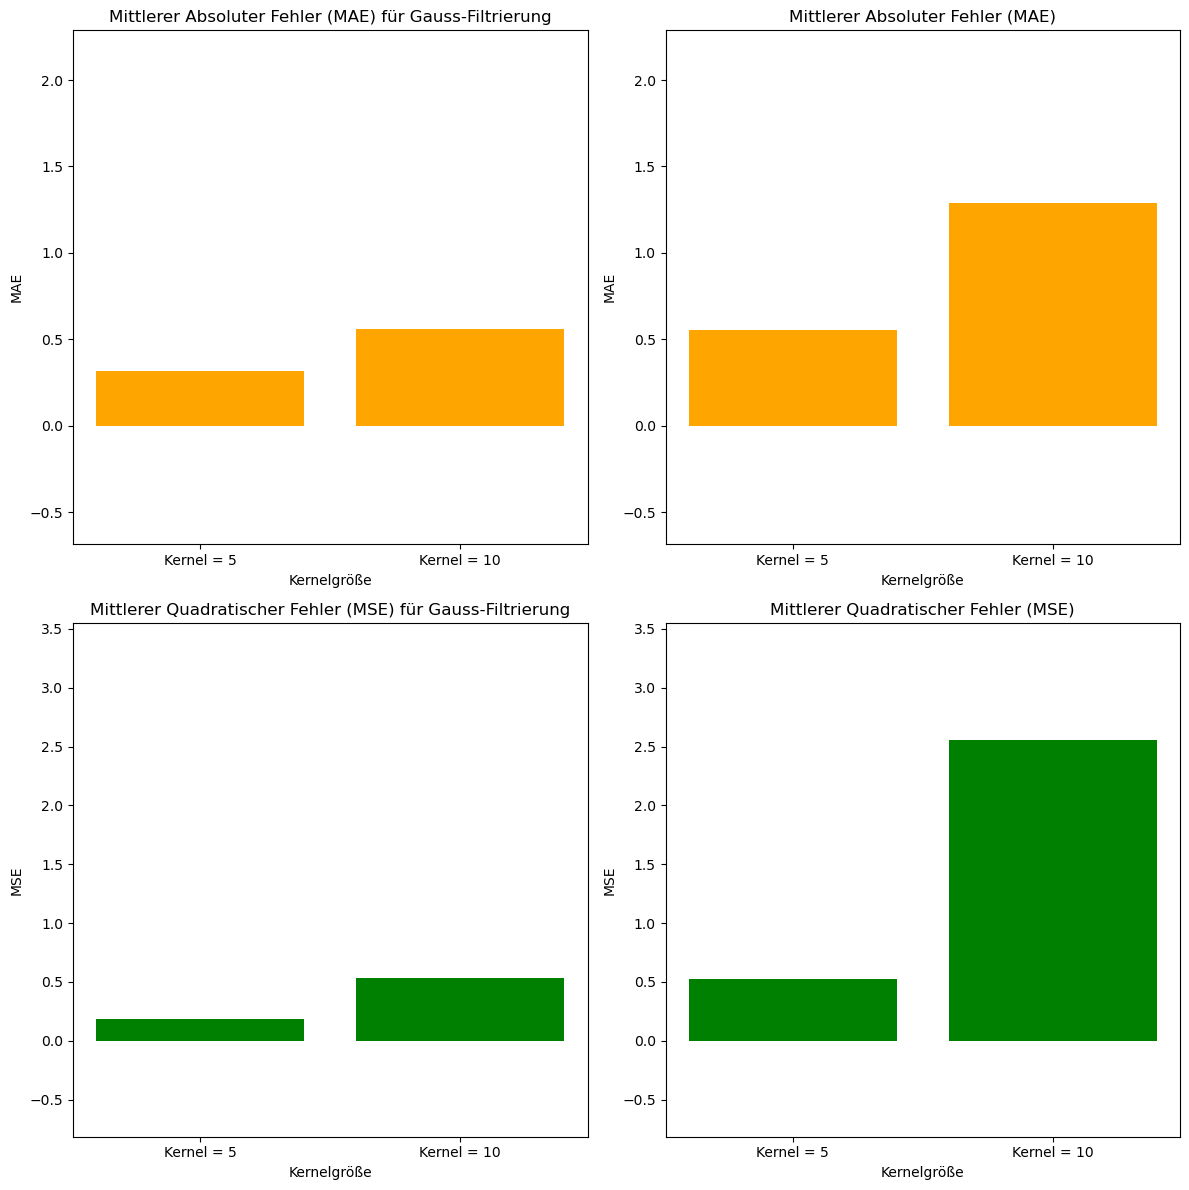

In [37]:
# Erstellen des Subplots für MAE und MSE
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Definiere den y-Achsenbereich für MAE
y_min_mae = min(min(mae_values), min(mae_values_gauss)) - 1
y_max_mae = max(max(mae_values), max(mae_values_gauss)) + 1

# Definiere den y-Achsenbereich für MSE
y_min_mse = min(min(mse_values), min(mse_values_gauss)) - 1
y_max_mse = max(max(mse_values), max(mse_values_gauss)) + 1

# MAE Plot für Gauss-Filtrierung
axs[0, 0].bar(error_labels_gauss, mae_values_gauss, color='orange')
axs[0, 0].set_title('Mittlerer Absoluter Fehler (MAE) für Gauss-Filtrierung')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].set_xlabel('Kernelgröße')
axs[0, 0].set_ylim([y_min_mae, y_max_mae])  # Setze den y-Bereich für MAE

# MAE Plot für Mittelwert-Filtrierung
axs[0, 1].bar(error_labels, mae_values, color='orange')
axs[0, 1].set_title('Mittlerer Absoluter Fehler (MAE)')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_xlabel('Kernelgröße')
axs[0, 1].set_ylim([y_min_mae, y_max_mae])  # Setze den y-Bereich für MAE

# MSE Plot für Gauss-Filtrierung
axs[1, 0].bar(error_labels_gauss, mse_values_gauss, color='green')
axs[1, 0].set_title('Mittlerer Quadratischer Fehler (MSE) für Gauss-Filtrierung')
axs[1, 0].set_ylabel('MSE')
axs[1, 0].set_xlabel('Kernelgröße')
axs[1, 0].set_ylim([y_min_mse, y_max_mse])  # Setze den y-Bereich für MSE

# MSE Plot für Mittelwert-Filtrierung
axs[1, 1].bar(error_labels, mse_values, color='green')
axs[1, 1].set_title('Mittlerer Quadratischer Fehler (MSE)')
axs[1, 1].set_ylabel('MSE')
axs[1, 1].set_xlabel('Kernelgröße')
axs[1, 1].set_ylim([y_min_mse, y_max_mse])  # Setze den y-Bereich für MSE

# Layout anpassen
plt.tight_layout()
plt.show()


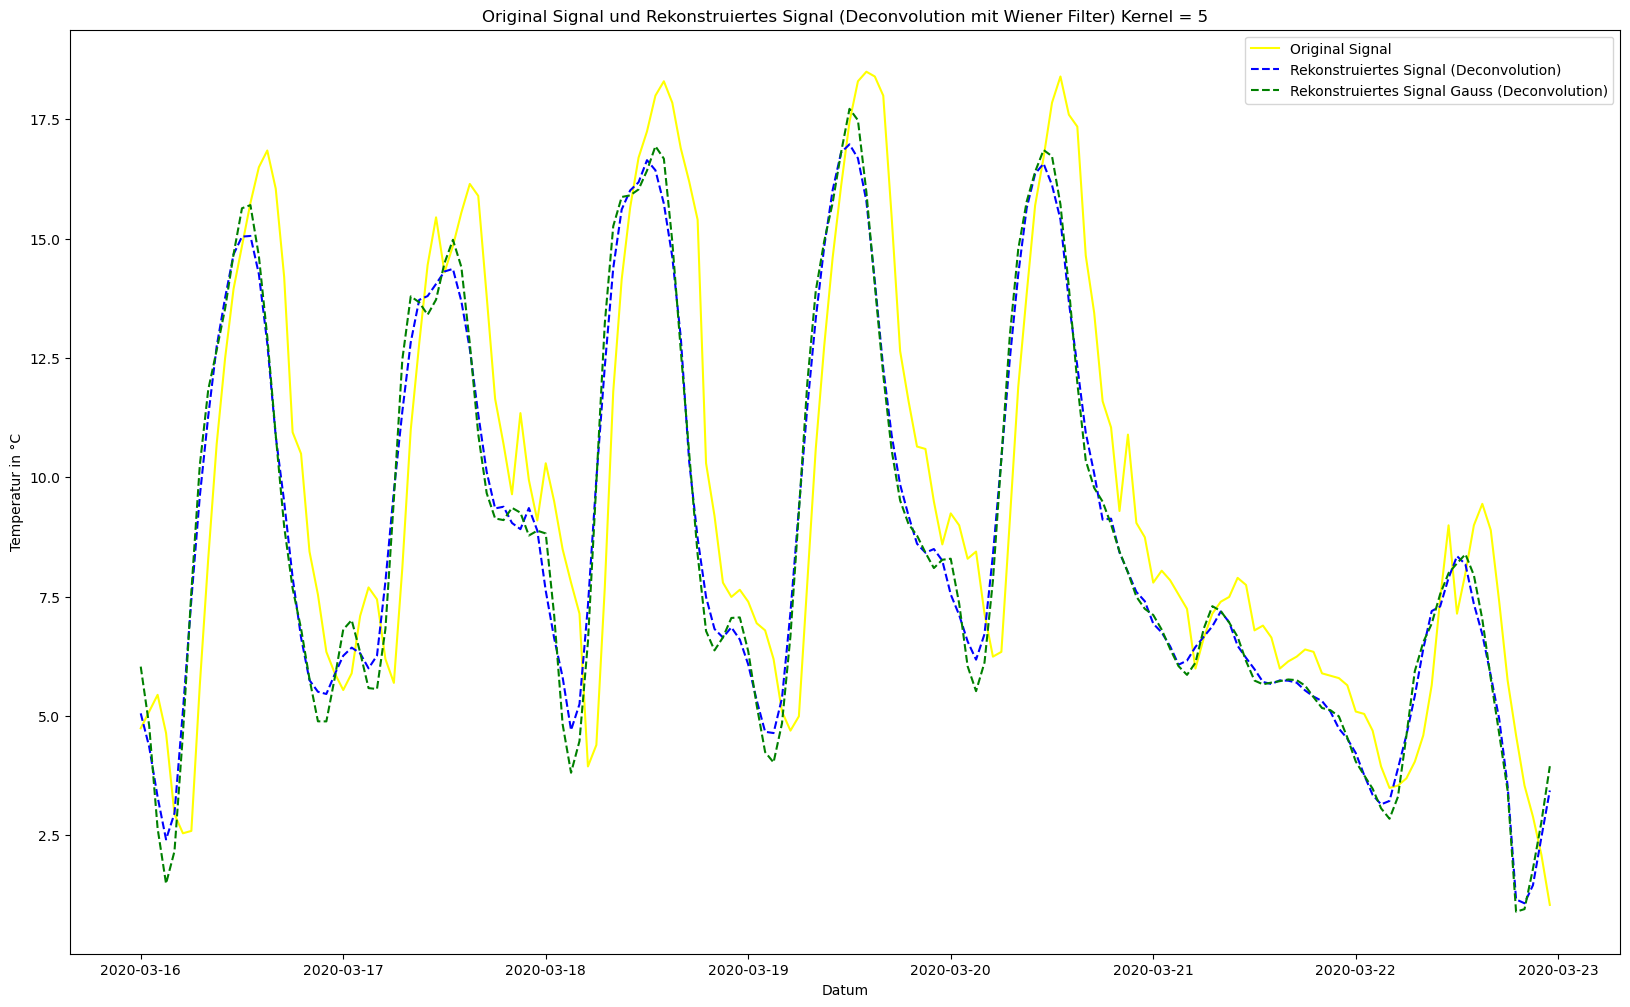

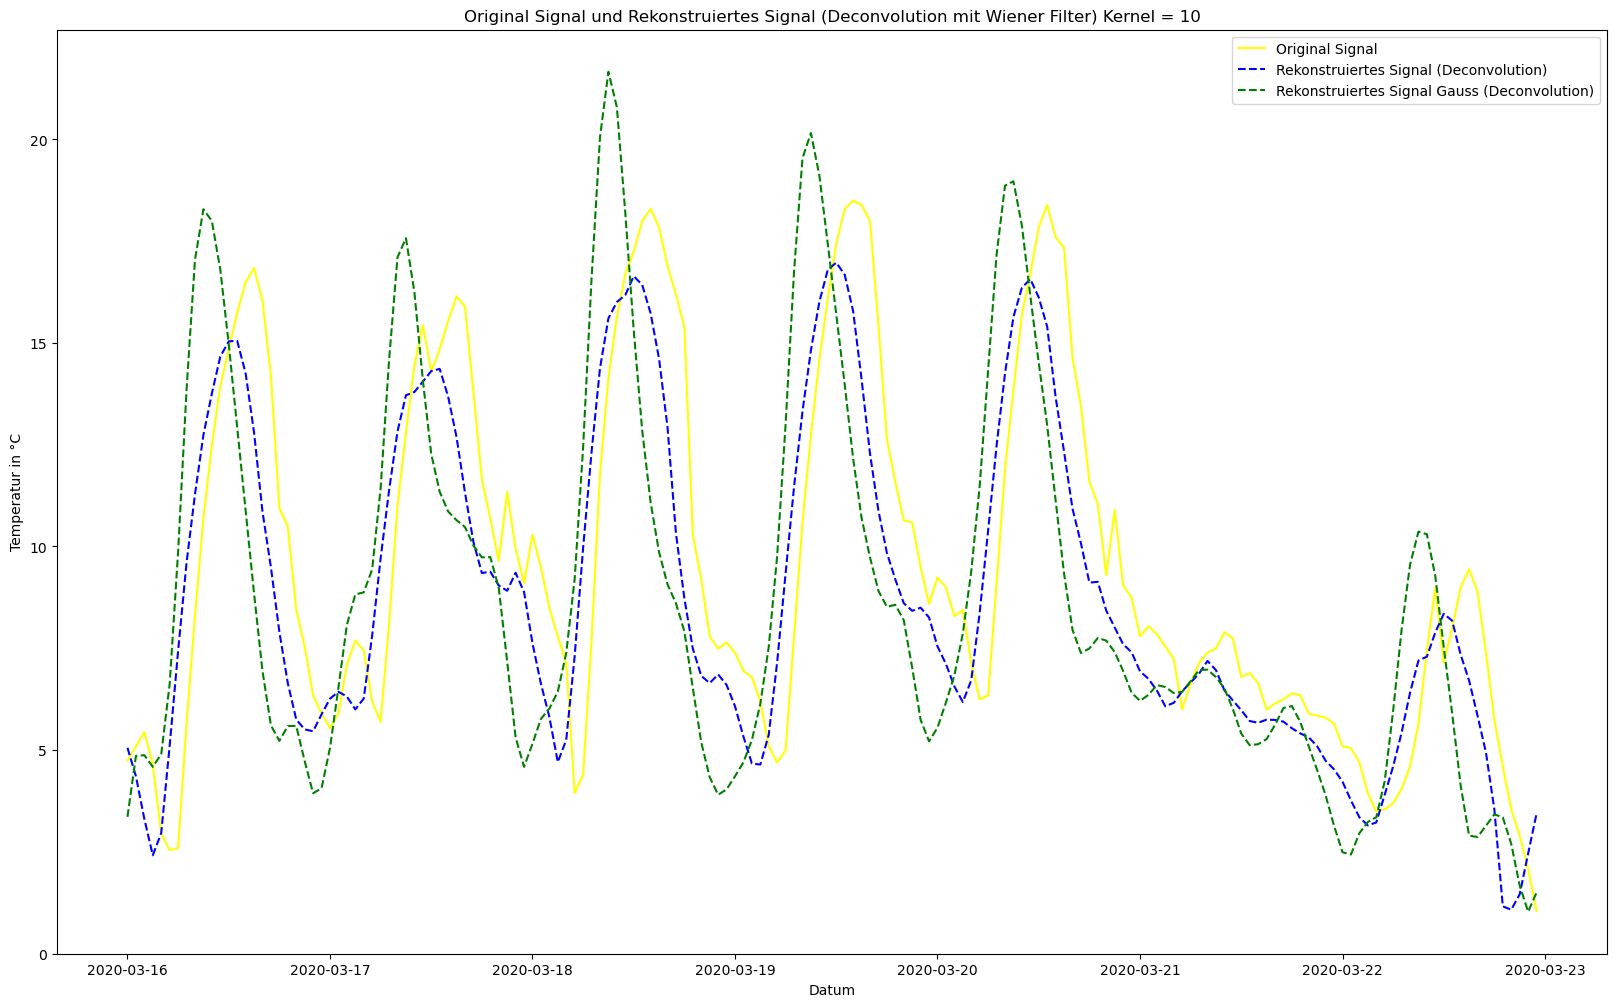

In [39]:
# Wiener Deconvolution
def wiener_deconvolution(filtered_signal, kernel_size, noise_estimation=0.09):
    kernel = np.ones(kernel_size) / kernel_size
    kernel_freq = np.fft.fft(kernel, len(filtered_signal))  # Fourier-Transformation des Kerns
    signal_freq = np.fft.fft(filtered_signal)  # Fourier-Transformation des gefilterten Signals
    
    # Wiener Deconvolution (berechnet den Filterinversen unter Annahme eines Rauschens)
    deconvolved_freq = (np.conj(kernel_freq) / (np.abs(kernel_freq)**2 + noise_estimation)) * signal_freq
    
    # Rücktransformation in den Zeitbereich
    deconvolved_signal = np.fft.ifft(deconvolved_freq).real
    return deconvolved_signal

# Anwenden der Wiener-Deconvolution auf das gefilterte Signal (Gaussian Kernel = 5)
deconvolved_signal_gaussian_5 = wiener_deconvolution(filtered_roi_signal_gaussian_5, kernel_size=5)
deconvolved_signal_gaussian_10 = wiener_deconvolution(filtered_roi_signal_gaussian_10, kernel_size=10)

# Plotten des Originalsignals, des gefilterten Signals und des rekonstruierbaren Signals (Deconvolution)
plt.figure(figsize=(20, 12))
plt.plot(roi_date, roi, label="Original Signal", linestyle="solid", color="yellow")
plt.plot(roi_date, deconvolved_signal_5, label="Rekonstruiertes Signal (Deconvolution)", linestyle="dashed", color="blue")
plt.plot(roi_date, deconvolved_signal_gaussian_5, label="Rekonstruiertes Signal Gauss (Deconvolution)", linestyle="dashed", color="green")
plt.legend()
plt.title("Original Signal und Rekonstruiertes Signal (Deconvolution mit Wiener Filter) Kernel = 5")
plt.ylabel("Temperatur in °C")
plt.xlabel("Datum")
plt.show()

# Plotten des Originalsignals, des gefilterten Signals und des rekonstruierbaren Signals (Deconvolution)
plt.figure(figsize=(20, 12))
plt.plot(roi_date, roi, label="Original Signal", linestyle="solid", color="yellow")
plt.plot(roi_date, deconvolved_signal_5, label="Rekonstruiertes Signal (Deconvolution)", linestyle="dashed", color="blue")
plt.plot(roi_date, deconvolved_signal_gaussian_10, label="Rekonstruiertes Signal Gauss (Deconvolution)", linestyle="dashed", color="green")
plt.legend()
plt.title("Original Signal und Rekonstruiertes Signal (Deconvolution mit Wiener Filter) Kernel = 10")
plt.ylabel("Temperatur in °C")
plt.xlabel("Datum")
plt.show()

### Diskussion

Die Konvolution mit dem Mittelwertfilter hat das Signal stärker geglättet als die Gauss-Konvolution, wodurch plötzliche Temperaturschwankungen weniger erkennbar sind. bei der Gauss-De-Konvolution fällt es auf, dass sie vorallem bei dem Kernel von 10 die spitzen extrem stark aufnimmt und diese wiederspiegelt, was dazu führt, dass die Mittelwert-De-Konvolution ruiger und richtiger erscheint, was auch an den MSE und MAE Werten wieder zu erkennen ist. Auffallend ist, dass die Gauss-Konvolution jedoch einen überaschenden geringeren fehler hat, als die Mittelwert Konvolution.

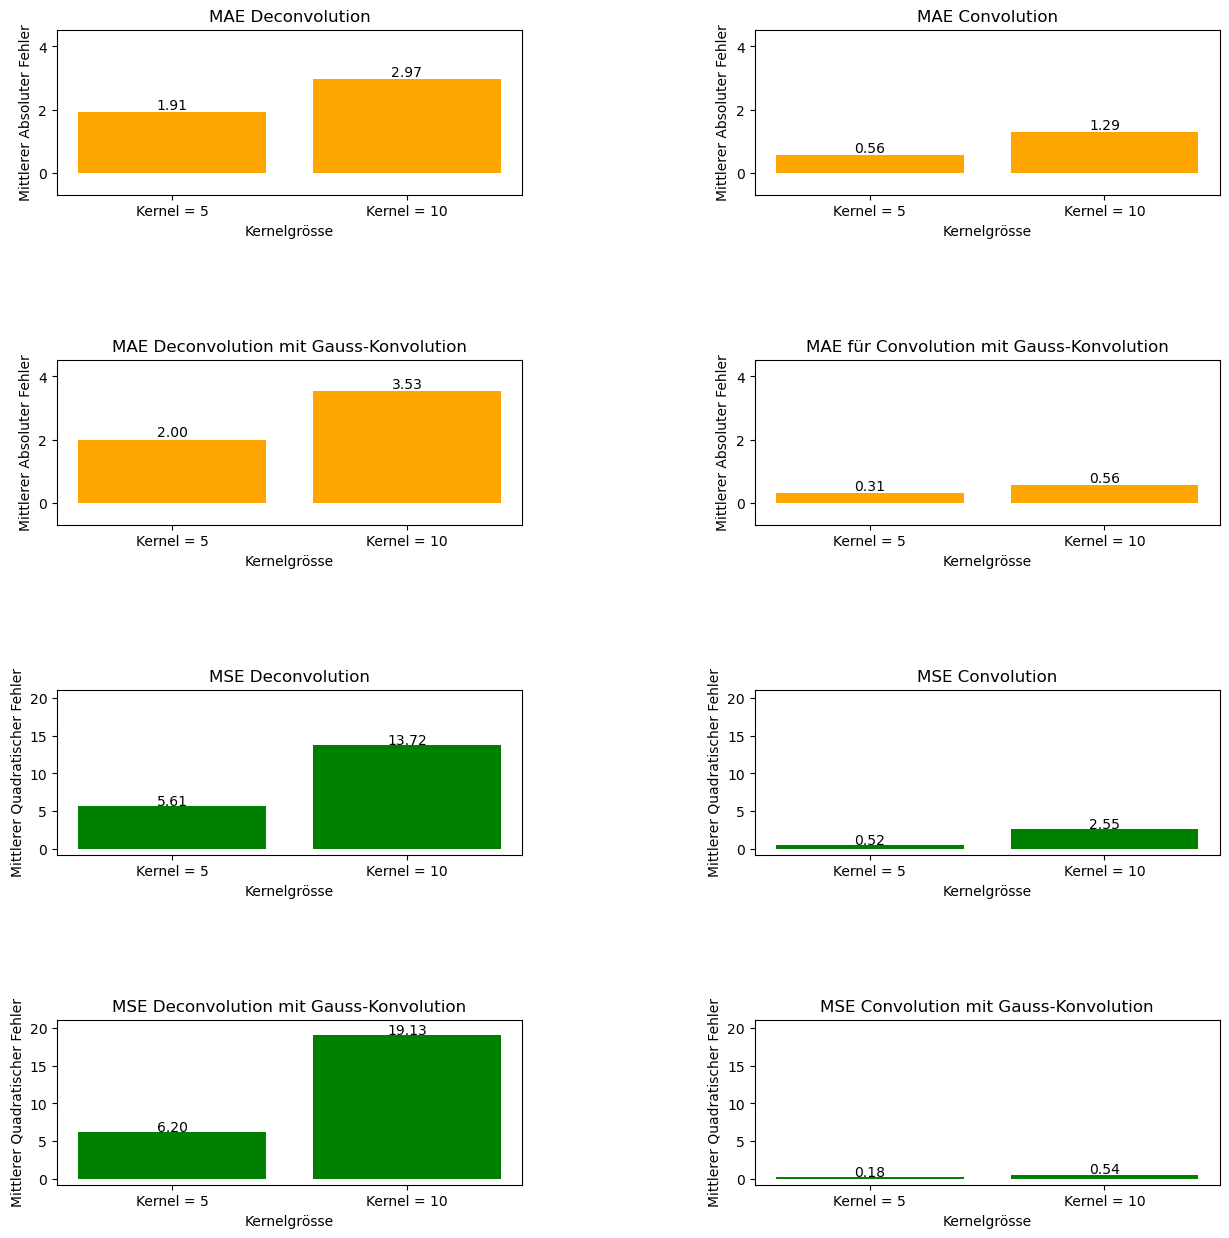

In [40]:
# Berechnen der Fehler für die verschiedenen Filter
mae_5_dec, mse_5_dec = calculate_errors(roi, deconvolved_signal_5)
mae_10_dec, mse_10_dec = calculate_errors(roi, deconvolved_signal_10)

# Plotten der Fehler (MAE und MSE)
error_labels_dec = ["Kernel = 5", "Kernel = 10"]
mae_values_dec = [mae_5_dec, mae_10_dec]
mse_values_dec = [mse_5_dec, mse_10_dec]

# Berechnen der Fehler für die verschiedenen Filter
mae_5_dec_gauss, mse_5_dec_gauss = calculate_errors(roi, deconvolved_signal_gaussian_5)
mae_10_dec_gauss, mse_10_dec_gauss = calculate_errors(roi, deconvolved_signal_gaussian_10)

# Plotten der Fehler (MAE und MSE)
error_labels_dec_gauss = ["Kernel = 5", "Kernel = 10"]
mae_values_dec_gauss = [mae_5_dec_gauss, mae_10_dec_gauss]
mse_values_dec_gauss = [mse_5_dec_gauss, mse_10_dec_gauss]

# Definiere den y-Achsenbereich für MAE
y_min_mae = min(min(mae_values), min(mae_values_gauss), min(mae_values_dec), min(mae_values_dec_gauss)) - 1
y_max_mae = max(max(mae_values), max(mae_values_gauss), max(mae_values_dec), max(mae_values_dec_gauss)) + 1

# Definiere den y-Achsenbereich für MSE
y_min_mse = min(min(mse_values), min(mse_values_gauss), min(mse_values_dec), min(mse_values_dec_gauss)) - 1
y_max_mse = max(max(mse_values), max(mse_values_gauss), max(mse_values_dec), max(mse_values_dec_gauss)) + 2

# Erstellen des Subplots für MAE und MSE
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

# MAE Plot
#dec
axs[0,0].bar(error_labels_dec, mae_values_dec, color='orange')
axs[0,0].set_title('MAE Deconvolution')
axs[0,0].set_ylabel('Mittlerer Absoluter Fehler')
axs[0,0].set_xlabel('Kernelgrösse')
axs[0,0].set_ylim([y_min_mae, y_max_mae])  # Setze den y-Bereich für MSE
for i, v in enumerate(mae_values_dec):
    axs[0,0].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


#con
axs[0,1].bar(error_labels, mae_values, color='orange')
axs[0,1].set_title('MAE Convolution')
axs[0,1].set_ylabel('Mittlerer Absoluter Fehler')
axs[0,1].set_xlabel('Kernelgrösse')
axs[0,1].set_ylim([y_min_mae, y_max_mae])  # Setze den y-Bereich für MSE
for i, v in enumerate(mae_values):
    axs[0,1].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


# dec Guass
axs[1,0].bar(error_labels_dec_gauss, mae_values_dec_gauss, color='orange')
axs[1,0].set_title('MAE Deconvolution mit Gauss-Konvolution')
axs[1,0].set_ylabel('Mittlerer Absoluter Fehler')
axs[1,0].set_xlabel('Kernelgrösse')
axs[1,0].set_ylim([y_min_mae, y_max_mae])  # Setze den y-Bereich für MSE
for i, v in enumerate(mae_values_dec_gauss):
    axs[1,0].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


# con_Gauss
axs[1, 1].bar(error_labels_gauss, mae_values_gauss, color='orange')
axs[1, 1].set_title('MAE für Convolution mit Gauss-Konvolution')
axs[1, 1].set_ylabel('Mittlerer Absoluter Fehler')
axs[1, 1].set_xlabel('Kernelgrösse')
axs[1, 1].set_ylim([y_min_mae, y_max_mae])  # Setze den y-Bereich für MAE
for i, v in enumerate(mae_values_gauss):
    axs[1,1].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)



# MSE Plot
# dec con
axs[2,0].bar(error_labels_dec, mse_values_dec, color='green')
axs[2,0].set_title('MSE Deconvolution')
axs[2,0].set_ylabel('Mittlerer Quadratischer Fehler')
axs[2,0].set_xlabel('Kernelgrösse')
axs[2,0].set_ylim([y_min_mse, y_max_mse])  # Setze den y-Bereich für MSE
for i, v in enumerate(mse_values_dec):
    axs[2,0].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


#con
axs[2,1].bar(error_labels, mse_values, color='green')
axs[2,1].set_title('MSE Convolution')
axs[2,1].set_ylabel('Mittlerer Quadratischer Fehler')
axs[2,1].set_xlabel('Kernelgrösse')
axs[2,1].set_ylim([y_min_mse, y_max_mse])  # Setze den y-Bereich für MSE
for i, v in enumerate(mse_values):
    axs[2,1].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


#dec Gauss
axs[3, 0].bar(error_labels_dec_gauss, mse_values_dec_gauss, color='green')
axs[3, 0].set_title('MSE Deconvolution mit Gauss-Konvolution')
axs[3, 0].set_ylabel('Mittlerer Quadratischer Fehler')
axs[3, 0].set_xlabel('Kernelgrösse')
axs[3, 0].set_ylim([y_min_mse, y_max_mse])  # Setze den y-Bereich für MSE
for i, v in enumerate(mse_values_dec_gauss):
    axs[3,0].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


#con Gauss
axs[3, 1].bar(error_labels_gauss, mse_values_gauss, color='green')
axs[3, 1].set_title('MSE Convolution mit Gauss-Konvolution')
axs[3, 1].set_ylabel('Mittlerer Quadratischer Fehler')
axs[3, 1].set_xlabel('Kernelgrösse')
axs[3, 1].set_ylim([y_min_mse, y_max_mse])  # Setze den y-Bereich für MSE
for i, v in enumerate(mse_values_gauss):
    axs[3,1].text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)


plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()